In [1]:
import netCDF4 as nc
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import collections
import xarray as xr
import statistics
import shapefile
from shapely.geometry import shape, Point
import imageio
import matplotlib.patches as patches
import plotly.express as px
from datetime import datetime
import random
from PIL import Image
from dateutil.relativedelta import relativedelta

In [ ]:
%run "/home/maiampow/code/git/DSSG2023-Groundwater/notebooks-and-markdowns/04C-Calculating Groundwater Anomaly.ipynb"

In [46]:
shpfl = gpd.read_file("/home/maiampow/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")
crb = shpfl[6:8]

In [28]:
#style preferences
plt.style.use('ggplot')
plt.rcParams["font.family"] = "FreeSans"

#colorblind palette
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [18]:
final_df

,time,lon,lat,storage_anomaly_km3,lwe_thickness_km3,uncertainty_km3,SWE_anomaly_km3,RM_anomaly_km3,gw_estimate_km3
0,2002-04-01,-107.875,36.125,0.0,-0.017167,0.156115,-3.884034e-04,-0.014085,-0.002694
1,2002-04-01,-107.875,36.375,0.0,-0.017167,0.156115,-6.934380e-04,-0.014051,-0.002423
2,2002-04-01,-107.625,36.125,0.0,-0.017167,0.156115,-5.973191e-04,-0.013984,-0.002585
3,2002-04-01,-107.625,36.375,0.0,-0.017167,0.156115,-7.805628e-04,-0.016554,0.000167
4,2002-04-01,-107.875,36.625,0.0,-0.017056,0.155110,-4.234757e-04,-0.013172,-0.003461
...,...,...,...,...,...,...,...,...,...
256260,2023-03-01,-117.125,33.625,0.0,-0.540799,0.074219,-1.307943e-07,0.057615,-0.598414
256261,2023-03-01,-117.125,33.875,0.0,-0.540799,0.074219,-1.645167e-07,0.064132,-0.604931
256267,2023-03-01,-117.375,33.375,0.0,-0.543932,0.074649,-1.232801e-08,0.065363,-0.609295
256268,2023-03-01,-117.125,33.125,0.0,-0.543932,0.074649,-8.878997e-09,0.037581,-0.581513


In [19]:
aggregated_df = final_df.groupby("time").mean().reset_index()

## Individual Variables

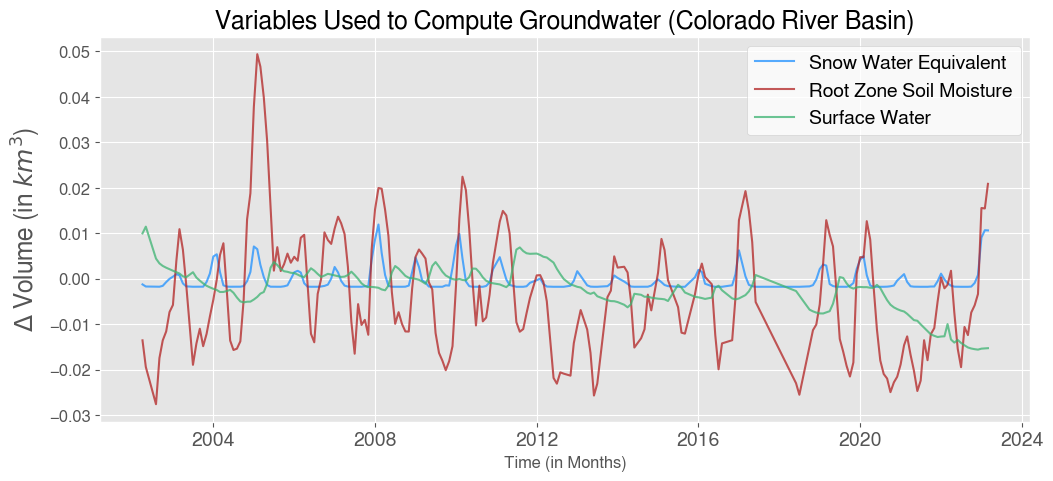

In [22]:
plt.figure(figsize=(12,5))

plt.plot(aggregated_df["time"],aggregated_df["SWE_anomaly_km3"],color="dodgerblue",label="Snow Water Equivalent",alpha=0.75)
plt.plot(aggregated_df["time"],aggregated_df["RM_anomaly_km3"],color="firebrick",label="Root Zone Soil Moisture",alpha=0.75)
plt.plot(aggregated_df["time"],aggregated_df["storage_anomaly_km3"],color="mediumseagreen",label="Surface Water",alpha=0.75)

plt.title("Variables Used to Compute Groundwater (Colorado River Basin)",fontsize=18)
plt.xlabel("Time (in Months)")
plt.ylabel("$\Delta$ Volume (in $km^3$)",fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.legend(facecolor="white",fontsize=14)

plt.show()

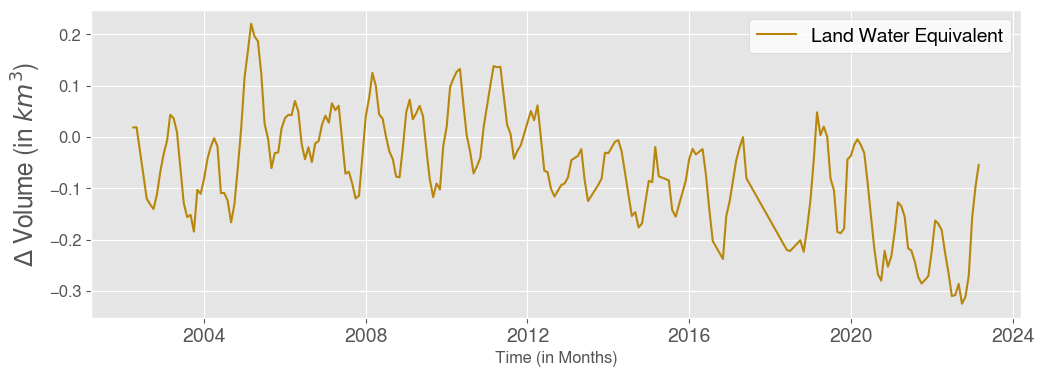

In [20]:
plt.figure(figsize=(12,4))

plt.plot(aggregated_df["time"],aggregated_df["lwe_thickness_km3"],color="darkgoldenrod",label="Land Water Equivalent")

plt.xlabel("Time (in Months)")
plt.ylabel("$\Delta$ Volume (in $km^3$)",fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.legend(facecolor="white",fontsize=14)

plt.show()

## Aggregation Over Entire Basin

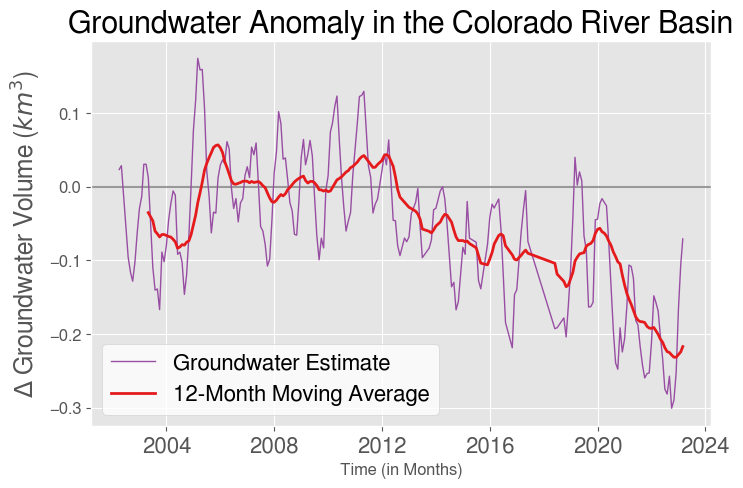

In [31]:
plt.rcParams["font.family"] = "FreeSans"


plt.figure(figsize=(8,5))

plt.axhline([0],color=CB_color_cycle[6],label="_nolegend_")

plt.plot(aggregated_df["time"],aggregated_df["gw_estimate_km3"],color=CB_color_cycle[5],linewidth=1)
plt.plot(aggregated_df["time"],aggregated_df["gw_estimate_km3"].rolling(window=12).mean(),color=CB_color_cycle[7],linewidth=2)

plt.title("Groundwater Anomaly in the Colorado River Basin",fontsize=22)
plt.xlabel("Time (in Months)",fontsize=12)
plt.ylabel("$\Delta$ Groundwater Volume ($km^3$)",fontsize=18)


plt.yticks(fontsize=12)
plt.xticks(fontsize=16)

plt.legend(["Groundwater Estimate","12-Month Moving Average"],facecolor="w",fontsize=16)

plt.show()

## Temporal Spatial Trends

In [ ]:
filenames = []
i = 0

for tp in final_df["time"].unique():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    crb.plot(color="white", ax=ax, edgecolor='black')
    
    sub_df = final_df[final_df["time"] == tp]

    x = sub_df['lon']
    y = sub_df['lat']
    z = sub_df['gw_estimate_km3']
    plt.scatter(x, y, c=z,
                cmap='RdYlBu',marker="s", sizes=[27]*len(x))
    plt.colorbar(label='Groundwater Volume Anomaly ($km^3$)')
    plt.ylim([30,44])
    plt.xlim([-121,-101])
    plt.clim(-0.3,0.3)
    plt.title(str(tp)[0:7])
    
    filename = f'{i}.png'
    i+=1
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    
# build gif
with imageio.get_writer('DESIREDPATH', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [ ]:
#making gif loop infinitely 

a = Image.open("DESIREDPATH")

a.save('DESIREDPATH',
               save_all=True, loop=0) 

## Wet & Dry Months

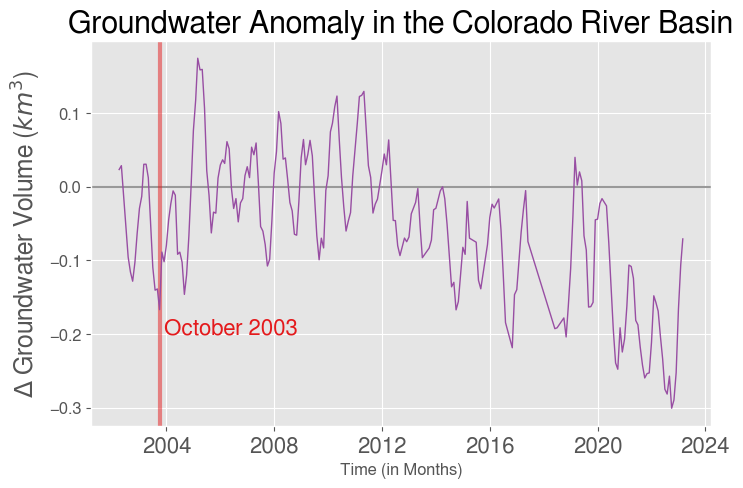

In [68]:
plt.figure(figsize=(8,5))

plt.axhline([0],color=CB_color_cycle[6],label="_nolegend_")

plt.axvline(aggregated_df["time"][15],color=CB_color_cycle[7],label="_nolegend_",linewidth=3,alpha=0.5)
plt.text(aggregated_df["time"][17],-0.2,"October 2003",c=CB_color_cycle[7],fontsize=16)


plt.plot(aggregated_df["time"],aggregated_df["gw_estimate_km3"],color=CB_color_cycle[5],linewidth=1)

plt.title("Groundwater Anomaly in the Colorado River Basin",fontsize=22)
plt.xlabel("Time (in Months)",fontsize=12)
plt.ylabel("$\Delta$ Groundwater Volume ($km^3$)",fontsize=18)

plt.yticks(fontsize=12)
plt.xticks(fontsize=16)

plt.show()

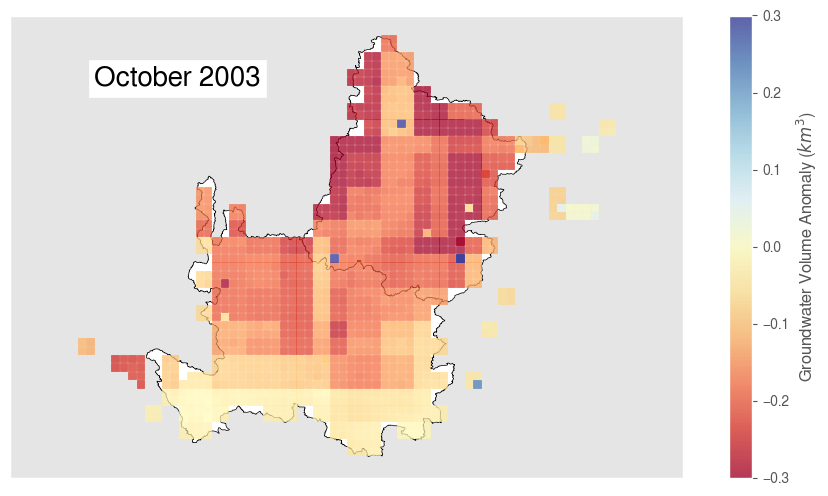

In [59]:
tp = aggregated_df["time"][15]

fig, ax = plt.subplots(figsize=(12, 6))
crb.plot(color="white", ax=ax, edgecolor='black',facecolor="k")

sub_df = final_df[final_df["time"] == tp]

x = sub_df['lon']
y = sub_df['lat']
z = sub_df['gw_estimate_km3']
plt.scatter(x, y, c=z,
            cmap='RdYlBu',marker="s", sizes=[29]*len(x),alpha=0.75)
plt.colorbar(label='Groundwater Volume Anomaly ($km^3$)')

plt.xticks([])
plt.xlim([-121,-101])
plt.yticks([])
plt.clim(-0.3,0.3)

plt.text(-118.5,42,"October 2003",fontsize=20,backgroundcolor="w")


plt.show()

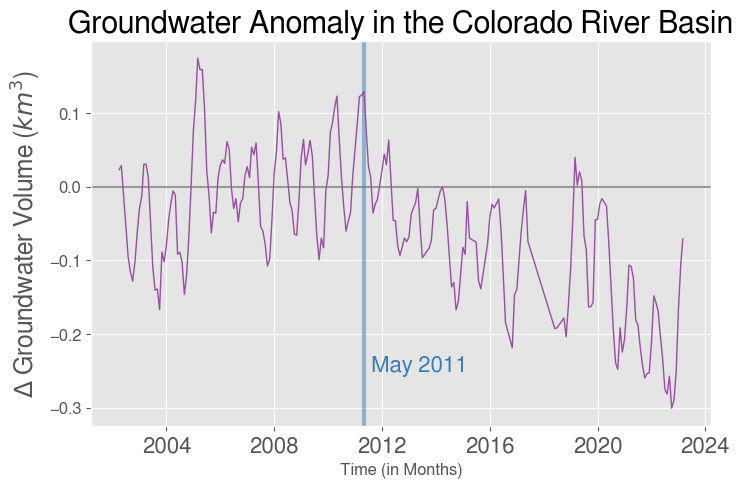

In [78]:
plt.figure(figsize=(8,5))

plt.axhline([0],color=CB_color_cycle[6],label="_nolegend_")

plt.axvline(aggregated_df["time"][105],color=CB_color_cycle[0],label="_nolegend_",linewidth=3,alpha=0.5)
plt.text(aggregated_df["time"][107],-0.25,"May 2011",c=CB_color_cycle[0],fontsize=16)

plt.plot(aggregated_df["time"],aggregated_df["gw_estimate_km3"],color=CB_color_cycle[5],linewidth=1)

plt.title("Groundwater Anomaly in the Colorado River Basin",fontsize=22)
plt.xlabel("Time (in Months)",fontsize=12)
plt.ylabel("$\Delta$ Groundwater Volume ($km^3$)",fontsize=18)

plt.yticks(fontsize=12)
plt.xticks(fontsize=16)

plt.show()

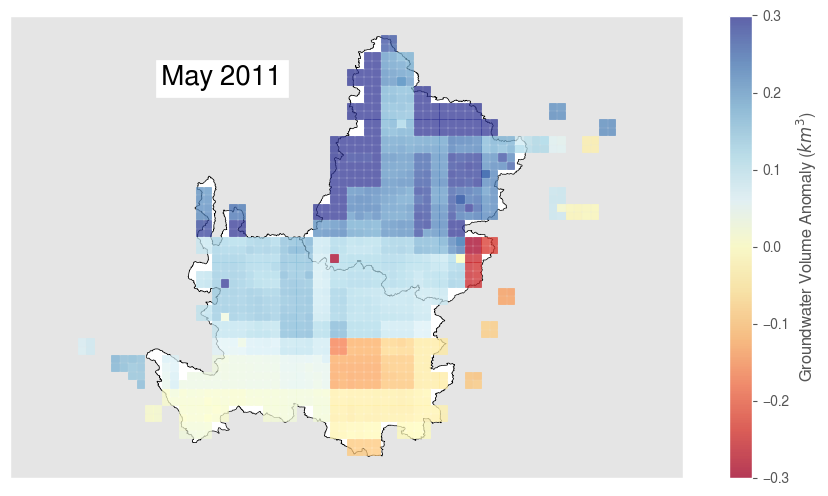

In [57]:
tp = aggregated_df["time"][105]

fig, ax = plt.subplots(figsize=(12, 6))
crb.plot(color="white", ax=ax, edgecolor='black',facecolor="k")

sub_df = final_df[final_df["time"] == tp]

x = sub_df['lon']
y = sub_df['lat']
z = sub_df['gw_estimate_km3']
plt.scatter(x, y, c=z,
            cmap='RdYlBu',marker="s", sizes=[29]*len(x),alpha=0.75)
plt.colorbar(label='Groundwater Volume Anomaly ($km^3$)')

plt.xticks([])
plt.xlim([-121,-101])
plt.yticks([])
plt.clim(-0.3,0.3)

plt.text(-116.5,42,"May 2011",fontsize=20,backgroundcolor="w")


plt.show()

## Upper Basin vs. Lower Basin

In [70]:
u = shpfl[7:8]

# Create a GeoDataFrame directly from grace_df
gdf_u = gpd.GeoDataFrame(final_df, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(final_df['lon'], final_df['lat']))

# Ensure the CRS for basin_shapefile is set correctly
u.crs = "EPSG:4326"

# Use sjoin to find points that intersect with the shapefile
intersected = gpd.sjoin(gdf_u, u, how="inner", predicate="intersects")

# Select the columns we are interested in
u_df = intersected[['lon', 'lat', 'time', 'gw_estimate_km3']]

In [71]:
l = shpfl[6:7]

# Create a GeoDataFrame directly from grace_df
gdf_l = gpd.GeoDataFrame(final_df, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(final_df['lon'], final_df['lat']))

# Ensure the CRS for basin_shapefile is set correctly
l.crs = "EPSG:4326"

# Use sjoin to find points that intersect with the shapefile
intersected = gpd.sjoin(gdf_l, l, how="inner", predicate="intersects")

# Select the columns we are interested in
l_df = intersected[['lon', 'lat', 'time', 'gw_estimate_km3']]

In [72]:
uppbagg = u_df.groupby("time").mean().reset_index()
lowbagg = l_df.groupby("time").mean().reset_index()

uppbagg['MA'] = uppbagg["gw_estimate_km3"].rolling(window=12).mean()
lowbagg['MA'] = lowbagg["gw_estimate_km3"].rolling(window=12).mean()

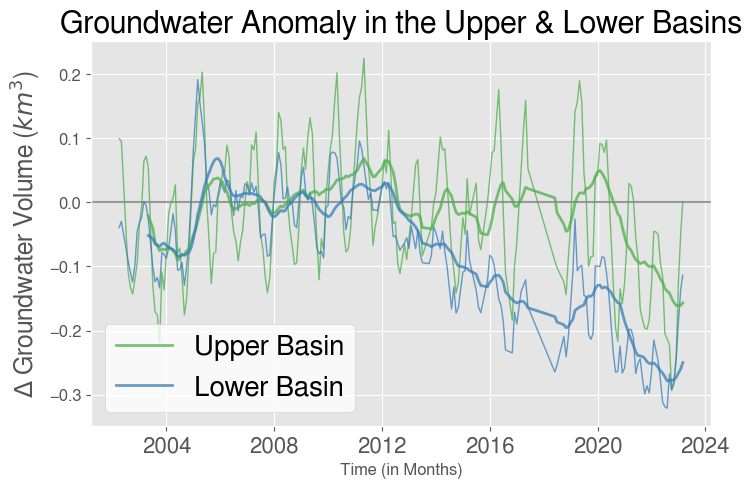

In [73]:
plt.figure(figsize=(8,5))

plt.axhline([0],color=CB_color_cycle[6])
plt.plot(uppbagg["time"],uppbagg["gw_estimate_km3"],color=CB_color_cycle[2], linewidth=1,label="__no label__",alpha=0.75)
plt.plot(lowbagg["time"],lowbagg["gw_estimate_km3"],color=CB_color_cycle[0], linewidth=1,label="__no label__",alpha=0.75)
plt.plot(uppbagg["time"],uppbagg["MA"],color=CB_color_cycle[2], linewidth=2,label="Upper Basin",alpha=0.75)
plt.plot(lowbagg["time"],lowbagg["MA"],color=CB_color_cycle[0], linewidth=2,label="Lower Basin",alpha=0.75)

plt.title("Groundwater Anomaly in the Upper & Lower Basins",fontsize=22)
plt.xlabel("Time (in Months)",fontsize=12)
plt.ylabel("$\Delta$ Groundwater Volume ($km^3$)",fontsize=18)

plt.yticks(fontsize=12)
plt.xticks(fontsize=16)
plt.legend(facecolor="white",fontsize=20)

plt.show()

## CRB States

In [74]:
states = ["New Mexico","California","Utah","Colorado","Wyoming","Nevada","Arizona"]

In [ ]:
state_df = pd.DataFrame()

for i in range(0,len(states)):
    
    st = states_shapefile[i:i+1]
    
    coords = st.get_coordinates()
    
    lon_min = min(coords['x'])
    lon_max = max(coords['x'])
    lat_min = min(coords['y'])
    lat_max = max(coords['y'])
    
    s_df = df[(df.lon> lon_min) & (df.lon < lon_max)]
    s_df = s_df[(s_df.lat> lat_min) & (s_df.lat < lat_max)]
    s_df = s_df[['lon', 'lat', 'time','gw_estimate_km3']]
    
    geo_gdf = gpd.GeoDataFrame(s_df, 
                                  crs='epsg:4326',
                                  geometry=gpd.points_from_xy(s_df['lon'], s_df['lat']))

    st.crs = "EPSG:4326"

    inters = gpd.sjoin(geo_gdf, st, how="inner", predicate="intersects")

    inters['state'] = [states[i]]*len(inters)
    
    state_df = pd.concat([state_df,inters])

In [ ]:
i=-1
plt.figure(figsize=(10,6))

for s in states:
    i+=1
    sub_df = state_df[state_df.state==s]
    sub_agg_df = sub_df[["time","gw_estimate_km3"]].groupby("time").mean().reset_index()
    plt.plot(sub_agg_df["time"],sub_agg_df["gw_estimate_km3"],label=s,color=CB_color_cycle[i],alpha=0.75,linewidth=1)

plt.title("Groundwater Anomaly in Colorado River Basin States",fontsize=20)
plt.xlabel("Time (in Months)",fontsize=12)
plt.ylabel("$\Delta$ Groundwater Volume ($km^3$)",fontsize=18)

plt.legend(facecolor="white",fontsize=10.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=16)

plt.show()